# Lesson 4: Data Augmentation with CIFAR-10

This notebook demonstrates data augmentation techniques using PyTorch and the CIFAR-10 dataset.

**Learning objectives:**
- Understand why data augmentation improves model generalization
- Apply common augmentation transforms to images
- Compare model performance with and without augmentation


In [1]:
%pip install fastai
%pip install torchvision
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
from fastai.callback.all import *

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
set_seed(42, reproducible=True)

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {"cuda" if torch.cuda.is_available() else "cpu"}')


PyTorch version: 2.9.1+cu128
Using device: cuda


## 1. Load CIFAR-10 Dataset

CIFAR-10 consists of 60,000 32×32 color images in 10 classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


In [3]:
# Download CIFAR-10 dataset
path = untar_data(URLs.CIFAR)
print(f'Dataset downloaded to: {path}')

# CIFAR-10 has 10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Classes: {classes}')
print(f'Total images: 60,000 (50,000 train + 10,000 test)')


Dataset downloaded to: /home/aghasi/.fastai/data/cifar10
Classes: ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Total images: 60,000 (50,000 train + 10,000 test)


## 2. Visualize Original Images


Sample images from CIFAR-10:


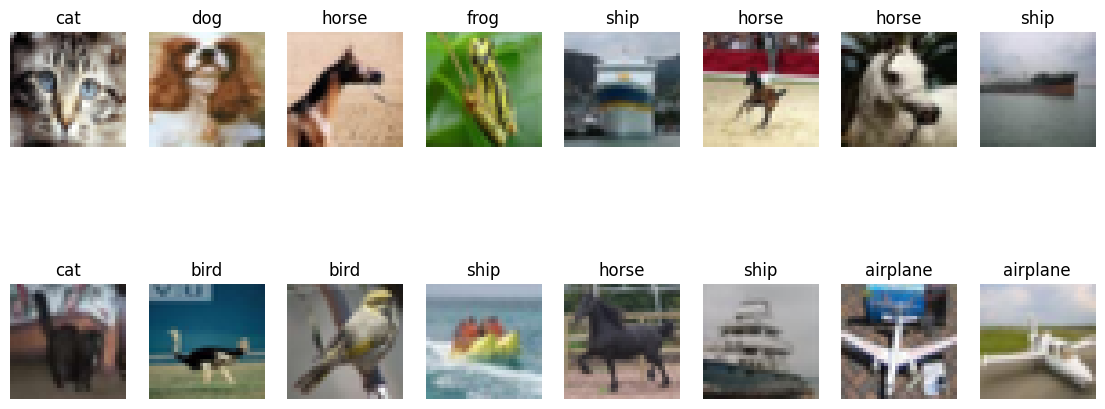

In [4]:
# Create a basic DataBlock to visualize original images
dblock_viz = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(32)
)

dls_viz = dblock_viz.dataloaders(path, bs=16)

# Show a batch of images
print('Sample images from CIFAR-10:')
dls_viz.show_batch(max_n=16, nrows=2, figsize=(14, 6))


## 3. Common Data Augmentation Techniques

Augmentation artificially expands the training set by applying random transformations:
- **RandomHorizontalFlip**: Flips images left-right
- **RandomCrop**: Crops random patches from images
- **ColorJitter**: Randomly changes brightness, contrast, saturation
- **RandomRotation**: Rotates images by random angles


In [5]:
# Create augmentation pipeline using FastAI
# aug_transforms provides common augmentations for computer vision
aug_tfms = aug_transforms(
    size=32,
    do_flip=True,          # Random horizontal flip
    flip_vert=False,       # Don't flip vertically (objects don't appear upside down)
    max_rotate=15.0,       # Random rotation up to 15 degrees
    max_lighting=0.3,      # Brightness/contrast adjustments
    max_warp=0.2,          # Perspective warping
    p_affine=0.75,         # Probability of applying geometric transforms
    p_lighting=0.75        # Probability of applying lighting transforms
)

print('Augmentation transforms configured:')
print('- Random horizontal flips')
print('- Random crops with padding')
print('- Random rotations (±15°)')
print('- Brightness and contrast adjustments')
print('- Perspective warping')


Augmentation transforms configured:
- Random horizontal flips
- Random crops with padding
- Random rotations (±15°)
- Brightness and contrast adjustments
- Perspective warping


## 4. Compare Original vs Augmented Images


Same images with augmentation applied:

Notice the variations:
- Some images are flipped horizontally
- Images have different brightness/contrast
- Slight rotations and perspective changes


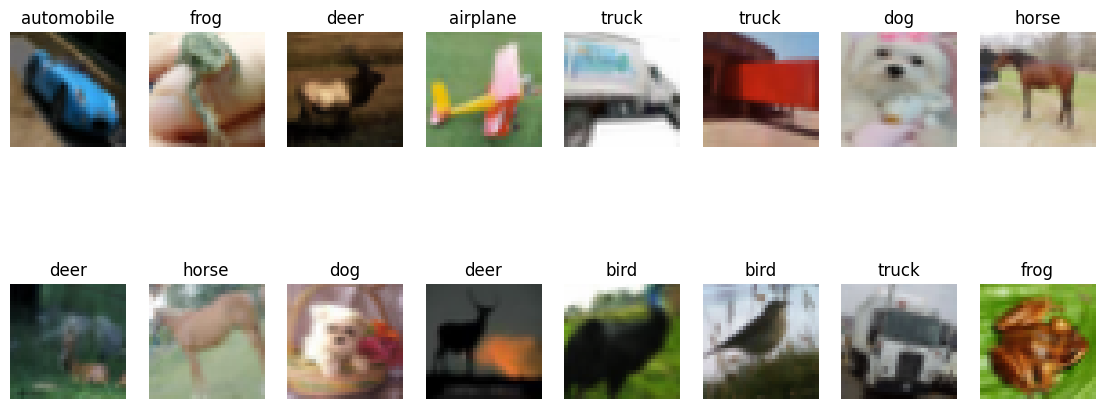

In [6]:
# Create a DataBlock with augmentation to visualize the effects
dblock_aug_viz = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(32),
    batch_tfms=[*aug_tfms, Normalize.from_stats(*cifar_stats)]
)

dls_aug_viz = dblock_aug_viz.dataloaders(path, bs=16)

# Visualize augmented images
print('Same images with augmentation applied:')
dls_aug_viz.show_batch(max_n=16, nrows=2, figsize=(14, 6))

print('\nNotice the variations:')
print('- Some images are flipped horizontally')
print('- Images have different brightness/contrast')
print('- Slight rotations and perspective changes')


## 5. Prepare Data with FastAI

FastAI provides a cleaner API for data loading and augmentation.


In [7]:
# Download and extract CIFAR-10 to a standard location
path = untar_data(URLs.CIFAR)
print(f'Data path: {path}')

# Create DataBlock WITHOUT augmentation (baseline)
dblock_basic = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(32),
    batch_tfms=[Normalize.from_stats(*cifar_stats)]
)

dls_basic = dblock_basic.dataloaders(path, bs=128)
print(f'Training batches: {len(dls_basic.train)}')
print(f'Validation batches: {len(dls_basic.valid)}')
print(f'Classes: {dls_basic.vocab}')


Data path: /home/aghasi/.fastai/data/cifar10
Training batches: 390
Validation batches: 79
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 6. Visualize with FastAI


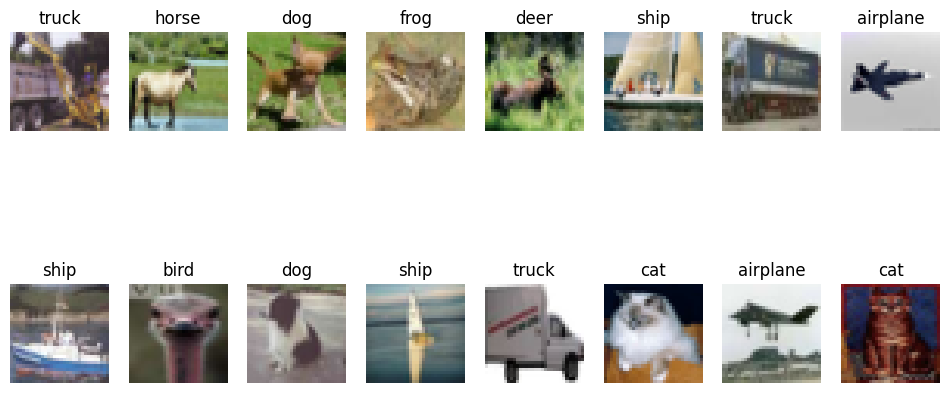

In [8]:
# FastAI's built-in visualization
dls_basic.show_batch(max_n=16, nrows=2, figsize=(12, 6))


## 7. Define Inception-based Model

We'll use a pretrained Inception (Xception) architecture, adapted for CIFAR-10.


In [9]:
# Create learner with Inception (xresnet) architecture
# xresnet is FastAI's improved version of ResNet with Inception-like improvements
learn_basic = vision_learner(
    dls_basic, 
    xresnet18,  # Inception-inspired architecture
    metrics=[accuracy, error_rate],
    loss_func=CrossEntropyLossFlat()
)

print(f'Model: xresnet18 (Inception-inspired architecture)')
print(f'Total parameters: {sum(p.numel() for p in learn_basic.model.parameters()):,}')


Model: xresnet18 (Inception-inspired architecture)
Total parameters: 11,728,224


## 8. Train Without Augmentation (Baseline)


In [10]:
freeze_epochs = 10
trian_epochs = 20

print('Training WITHOUT augmentation...')
learn_basic.fine_tune(trian_epochs, base_lr=3e-3, freeze_epochs=freeze_epochs)


Training WITHOUT augmentation...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.886310,1.417933,0.506800,0.493200,00:05
1,1.607500,1.299188,0.535900,0.464100,00:05
2,1.408557,1.249557,0.554500,0.445500,00:06
3,1.345814,1.228537,0.558500,0.441500,00:04
4,1.308898,1.214261,0.559000,0.441000,00:04
5,1.284384,1.193020,0.565400,0.434600,00:04
6,1.247106,1.180132,0.573300,0.426700,00:05
7,1.240190,1.153463,0.578600,0.421400,00:04
8,1.195327,1.118116,0.596800,0.403200,00:05
9,1.135046,1.092498,0.606500,0.393500,00:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.995519,0.980902,0.649100,0.350900,00:05
1,0.905959,0.908223,0.677300,0.322700,00:05
2,0.817188,0.840795,0.703200,0.296800,00:05
3,0.712166,0.788502,0.724000,0.276000,00:05
4,0.620542,0.758551,0.738600,0.261400,00:05
5,0.529709,0.756081,0.744300,0.255700,00:05
6,0.411195,0.824917,0.738300,0.261700,00:05
7,0.309952,0.846088,0.748400,0.251600,00:05
8,0.216669,0.950852,0.748500,0.251500,00:05
9,0.152124,1.073000,0.747900,0.252100,00:05


## 9. Create DataLoader WITH Augmentation


Augmented training samples:


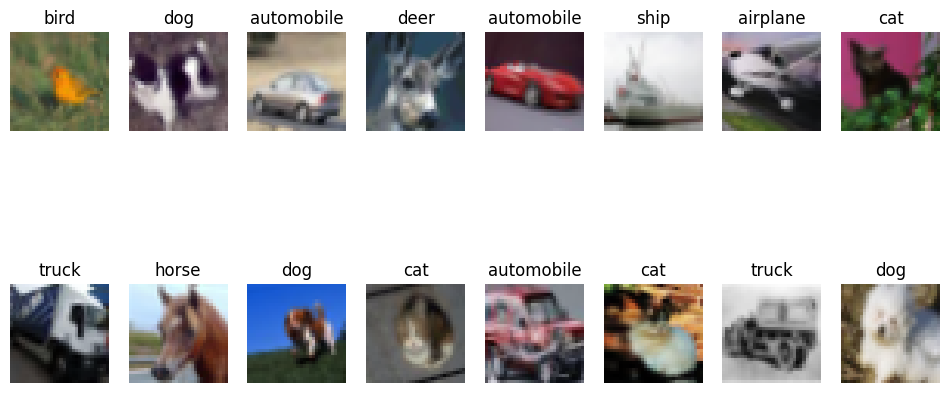

In [11]:
# Create DataBlock WITH augmentation using FastAI's aug_transforms
dblock_augmented = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(32),
    batch_tfms=[
        *aug_transforms(
            size=32,
            do_flip=True,
            flip_vert=False,
            max_rotate=15.0,
            max_lighting=0.3,
            max_warp=0.2,
            p_affine=0.75,
            p_lighting=0.75
        ),
        Normalize.from_stats(*cifar_stats)
    ]
)

dls_augmented = dblock_augmented.dataloaders(path, bs=128)

# Visualize augmented samples
print('Augmented training samples:')
dls_augmented.show_batch(max_n=16, nrows=2, figsize=(12, 6))


## 10. Train WITH Augmentation


In [12]:
print('Training WITH augmentation...')
learn_augmented = vision_learner(
    dls_augmented, 
    xresnet18,
    metrics=[accuracy, error_rate],
    loss_func=CrossEntropyLossFlat()
)

learn_augmented.fine_tune(trian_epochs, base_lr=3e-3, freeze_epochs=freeze_epochs)


Training WITH augmentation...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.031084,1.685556,0.454600,0.545400,00:05
1,1.725120,1.492278,0.491800,0.508200,00:06
2,1.529775,1.469138,0.486900,0.513100,00:06
3,1.421122,1.426390,0.499000,0.501000,00:05
4,1.409373,1.379285,0.511700,0.488300,00:05
5,1.396505,1.362961,0.508500,0.491500,00:06
6,1.381142,1.423608,0.500700,0.499300,00:06
7,1.359143,1.280761,0.543600,0.456400,00:05
8,1.316309,1.315477,0.535000,0.465000,00:05
9,1.282607,1.243736,0.560100,0.439900,00:06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.168636,1.114319,0.600100,0.399900,00:06
1,1.064315,1.065271,0.621100,0.378900,00:06
2,0.981921,0.941878,0.665800,0.334200,00:06
3,0.911865,0.929796,0.666900,0.333100,00:06
4,0.835916,0.828909,0.705900,0.294100,00:07
5,0.815882,0.761669,0.732500,0.267500,00:06
6,0.754755,0.788423,0.725600,0.274400,00:06
7,0.715629,0.771478,0.737500,0.262500,00:06
8,0.692178,0.690597,0.760300,0.239700,00:06
9,0.645587,0.691278,0.759600,0.240400,00:06


## 11. Compare Results

FastAI automatically tracks training history. Let's visualize and compare.


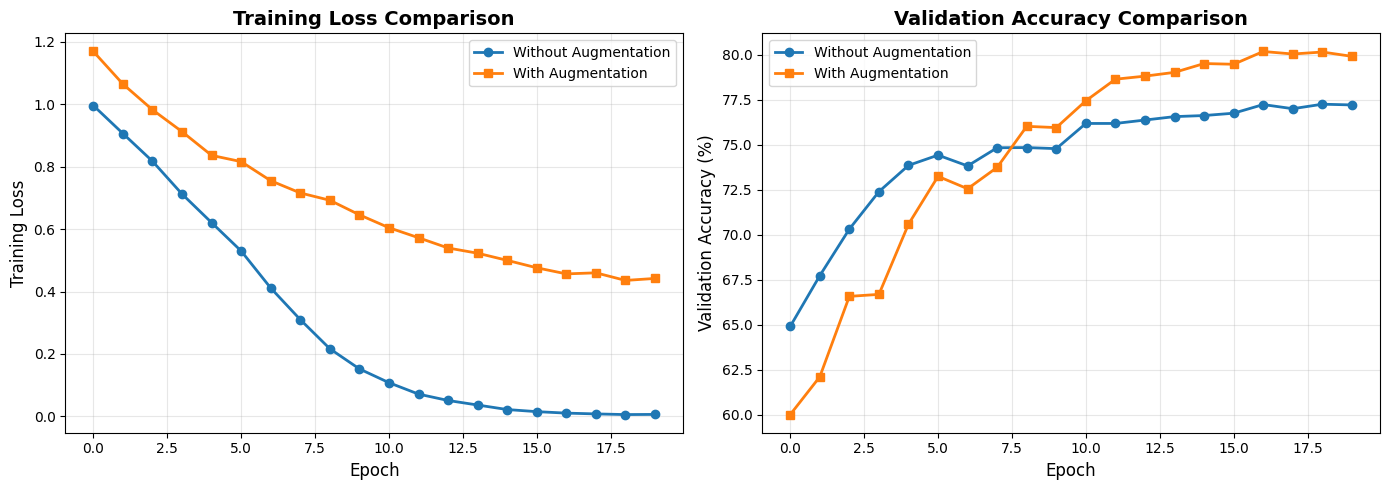


Final Results:
Without Augmentation: 77.22% accuracy
With Augmentation: 79.92% accuracy
Improvement: 2.70%


In [13]:
# Plot training history for both models

def _extract_history(learn):
    # Map fastai recorder values onto their metric names for easy lookup.
    metric_names = learn.recorder.metric_names[1:-1]
    if not learn.recorder.values:
        return {name: [] for name in metric_names}
    trimmed = [row[:len(metric_names)] for row in learn.recorder.values]
    columns = list(zip(*trimmed))
    return {name: list(columns[idx]) for idx, name in enumerate(metric_names)}

history_basic = _extract_history(learn_basic)
history_augmented = _extract_history(learn_augmented)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

basic_losses = history_basic.get('train_loss', [])
aug_losses = history_augmented.get('train_loss', [])

basic_acc = [val * 100 for val in history_basic.get('accuracy', [])]
aug_acc = [val * 100 for val in history_augmented.get('accuracy', [])]

# Plot training loss
ax1.plot(basic_losses, label='Without Augmentation', marker='o', linewidth=2)
ax1.plot(aug_losses, label='With Augmentation', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot validation accuracy
ax2.plot(basic_acc, label='Without Augmentation', marker='o', linewidth=2)
ax2.plot(aug_acc, label='With Augmentation', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if basic_acc and aug_acc:
    print()
    print('Final Results:')
    print(f'Without Augmentation: {basic_acc[-1]:.2f}% accuracy')
    print(f'With Augmentation: {aug_acc[-1]:.2f}% accuracy')
    print(f'Improvement: {aug_acc[-1] - basic_acc[-1]:.2f}%')
else:
    print('No recorded accuracy metrics available to summarize.')


## 12. Visualize Predictions

Let's see how each model performs on test images.


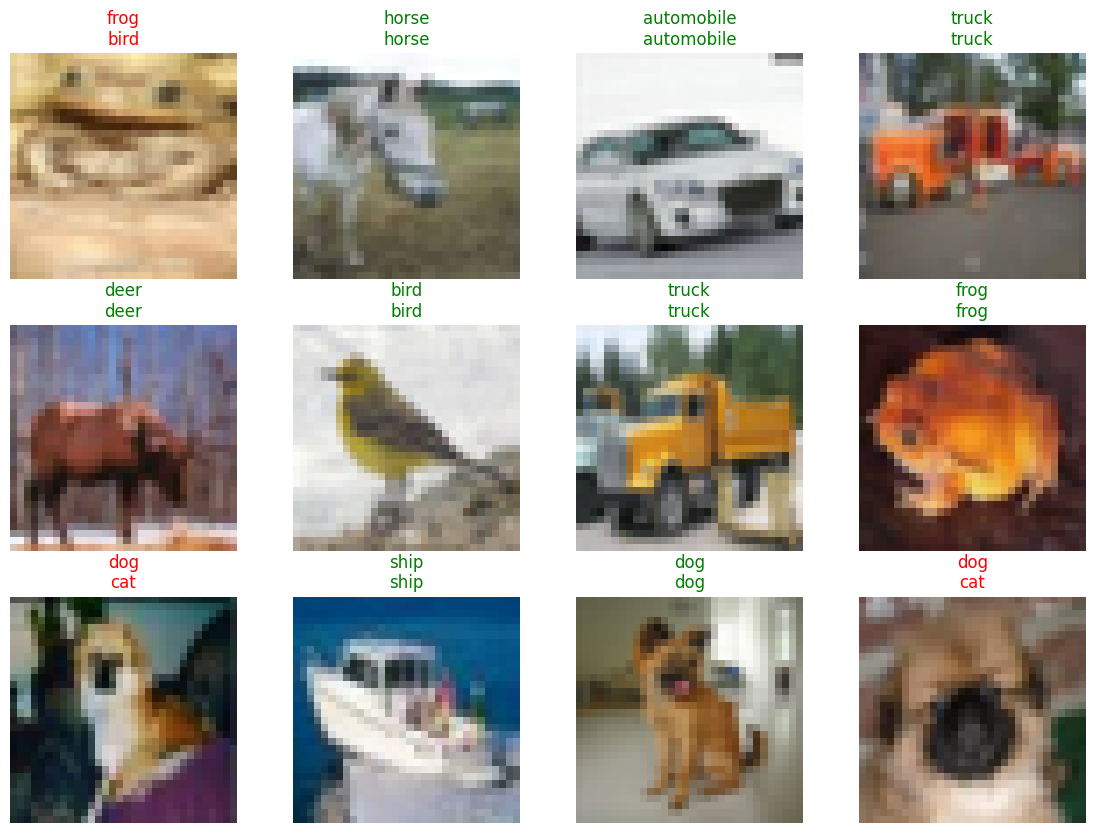

In [14]:
# Show predictions from augmented model
learn_augmented.show_results(max_n=12, figsize=(14, 10))


## 13. Confusion Matrix

Analyze which classes are most commonly confused.


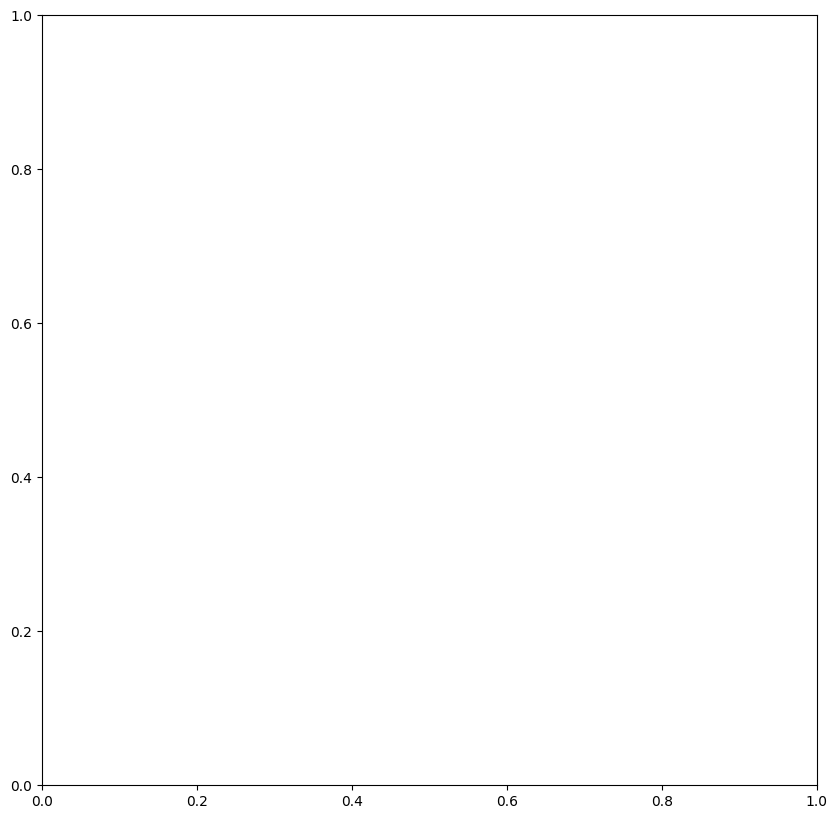

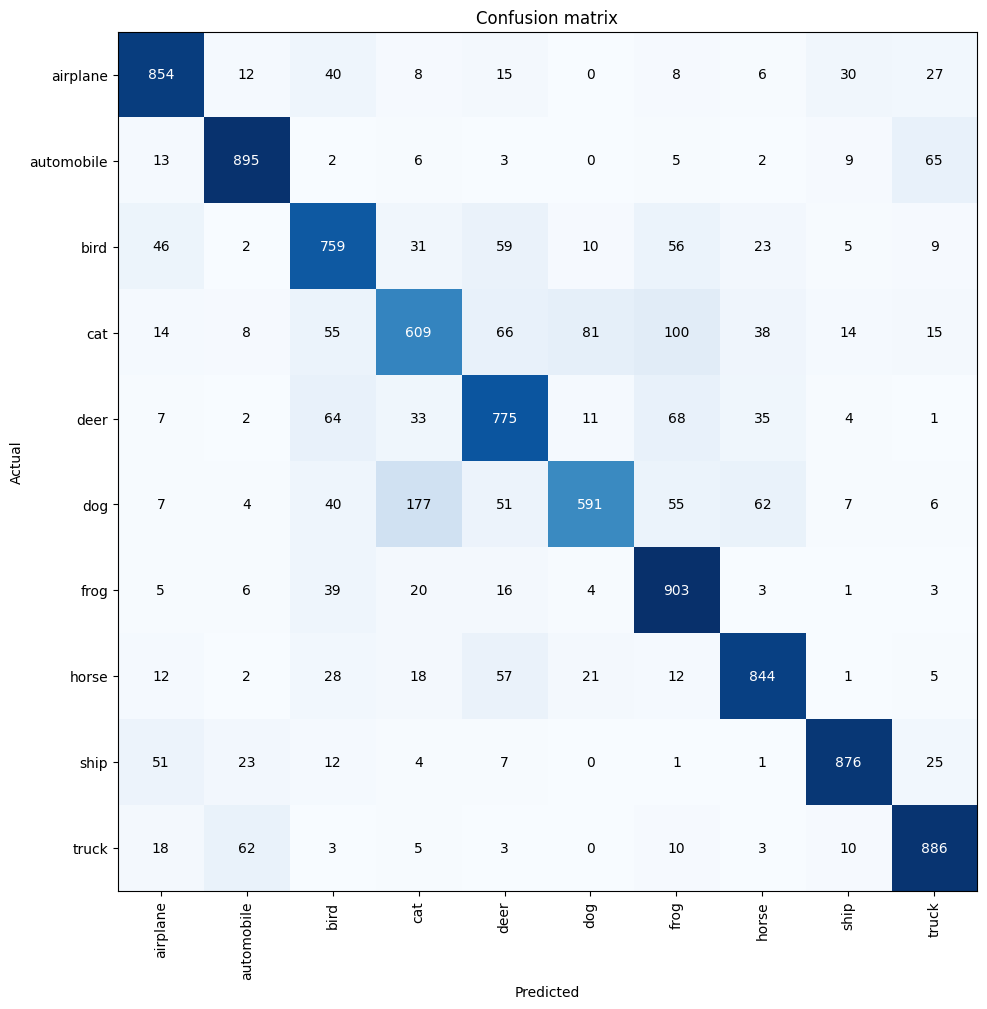


Most confused pairs:


[('dog', 'cat', np.int64(177)),
 ('cat', 'frog', np.int64(100)),
 ('cat', 'dog', np.int64(81)),
 ('deer', 'frog', np.int64(68)),
 ('cat', 'deer', np.int64(66)),
 ('automobile', 'truck', np.int64(65)),
 ('deer', 'bird', np.int64(64)),
 ('dog', 'horse', np.int64(62)),
 ('truck', 'automobile', np.int64(62)),
 ('bird', 'deer', np.int64(59)),
 ('horse', 'deer', np.int64(57)),
 ('bird', 'frog', np.int64(56)),
 ('cat', 'bird', np.int64(55)),
 ('dog', 'frog', np.int64(55)),
 ('dog', 'deer', np.int64(51)),
 ('ship', 'airplane', np.int64(51))]

In [15]:
# Get interpretation for augmented model
interp = ClassificationInterpretation.from_learner(learn_augmented)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
interp.plot_confusion_matrix(figsize=(10, 10))
plt.show()

# Show most confused classes
print('\nMost confused pairs:')
interp.most_confused(min_val=50)


## 14. Understanding the Inception Architecture

The xresnet architecture includes Inception-inspired improvements:
- **Depthwise separable convolutions**: More efficient than standard convolutions
- **Residual connections**: Help with gradient flow
- **Batch normalization**: Stabilizes training
- **Global average pooling**: Reduces parameters vs fully connected layers


## 15. Visualize the xResNet18 Architecture

Both the baseline and augmented learners share the same transfer-learning pipeline. The diagram below summarizes the major stages, from CIFAR-10 inputs through augmentation, the xResNet18 backbone, and the classification head.

## Key Takeaways

1. **Data augmentation** artificially expands the training set without collecting new data
2. **Common techniques**: flips, crops, rotations, color/lighting adjustments, warping
3. **Benefits**: Better generalization, reduced overfitting, improved test accuracy
4. **Inception architectures**: Use efficient depthwise separable convolutions and residual connections
5. **FastAI advantages**: Simplified API, automatic mixed precision, learning rate scheduling
6. **Best practice**: Apply augmentation only to training data, not validation/test data
7. **Transfer learning**: Fine-tuning pretrained models significantly improves performance on small datasets
